In [ ]:
import datetime
print datetime.datetime.now()

aaa-usa


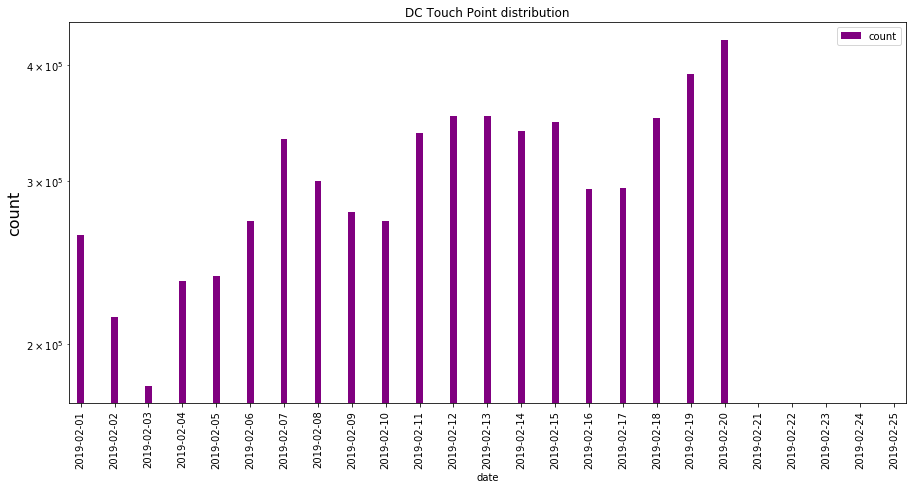

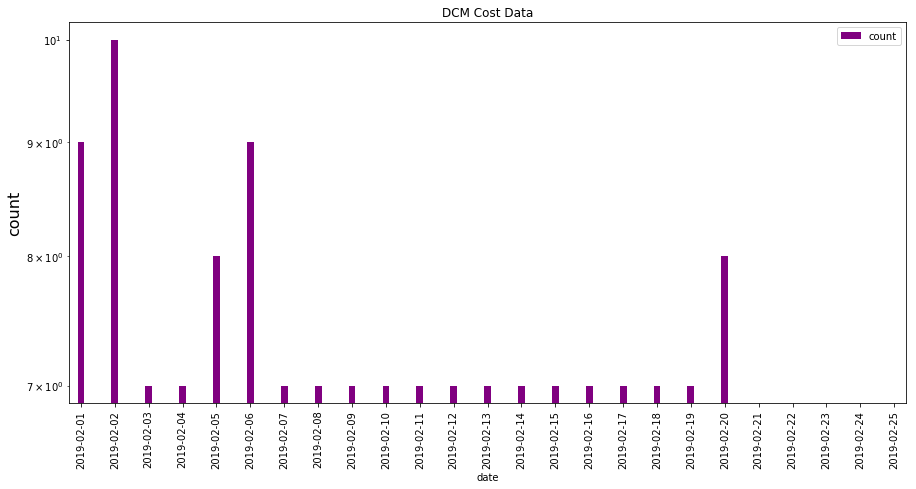

DCM_Cost Files not present to Plot DCM Spend



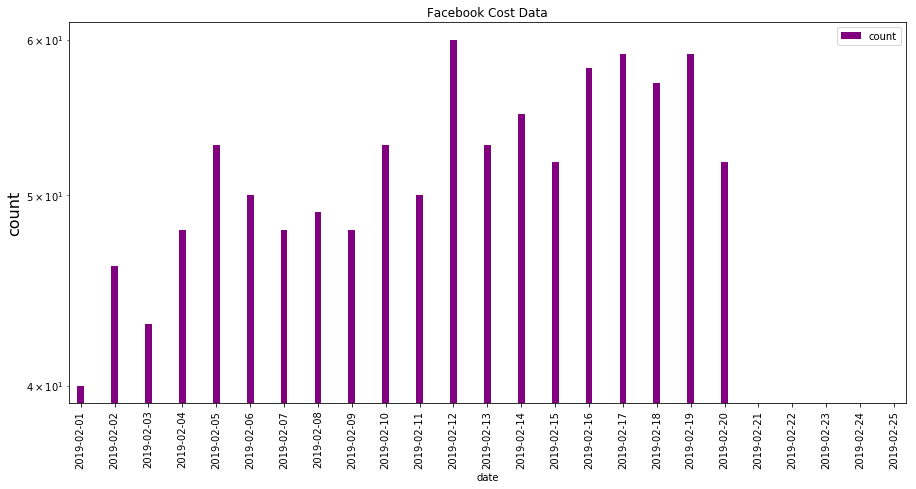

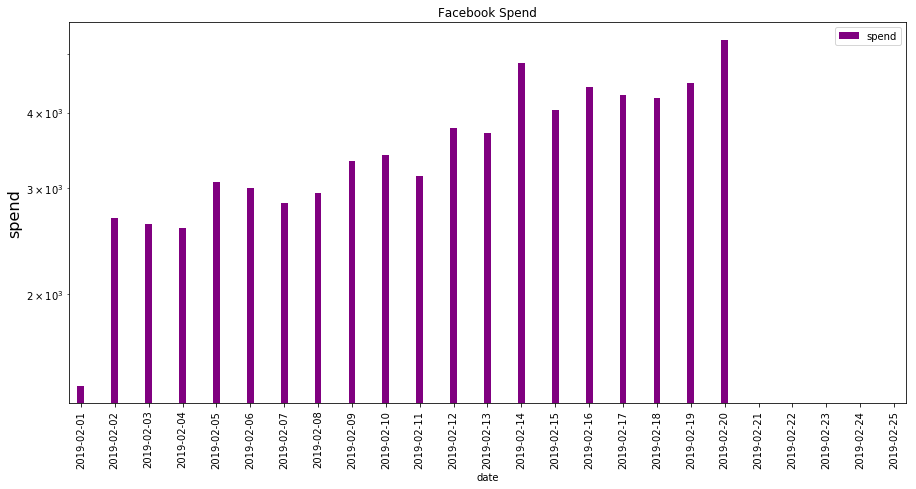

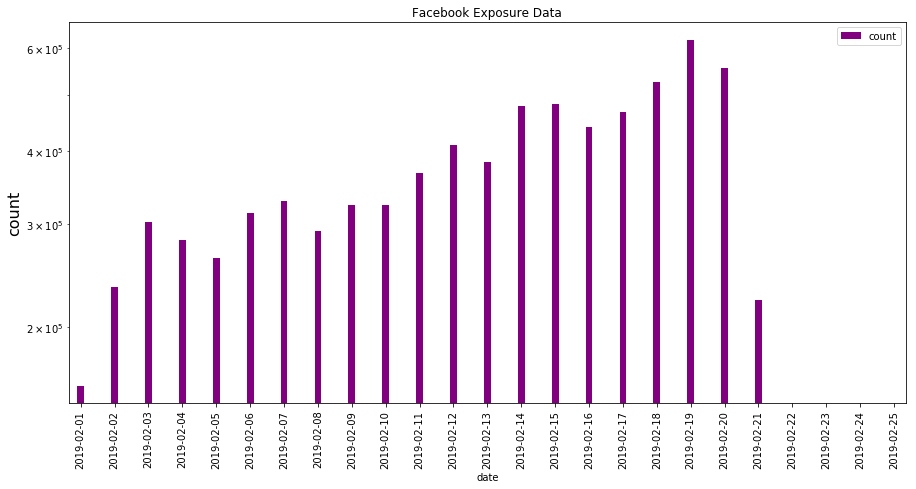

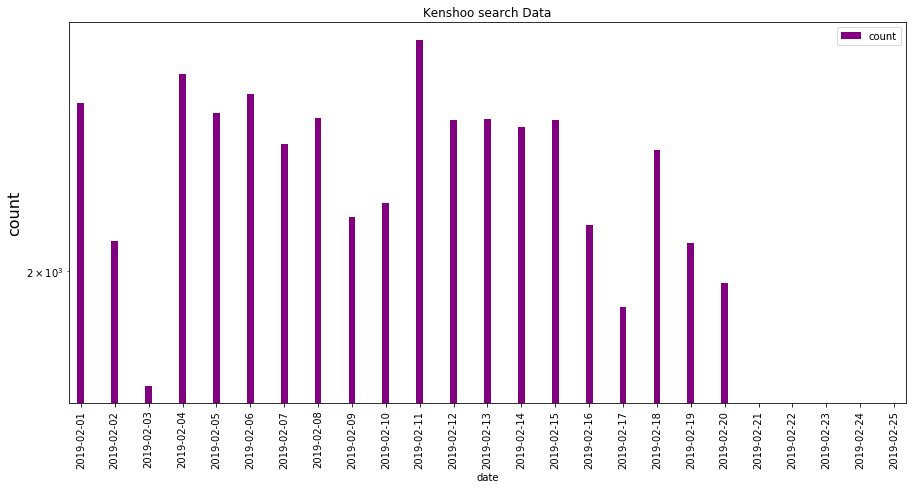

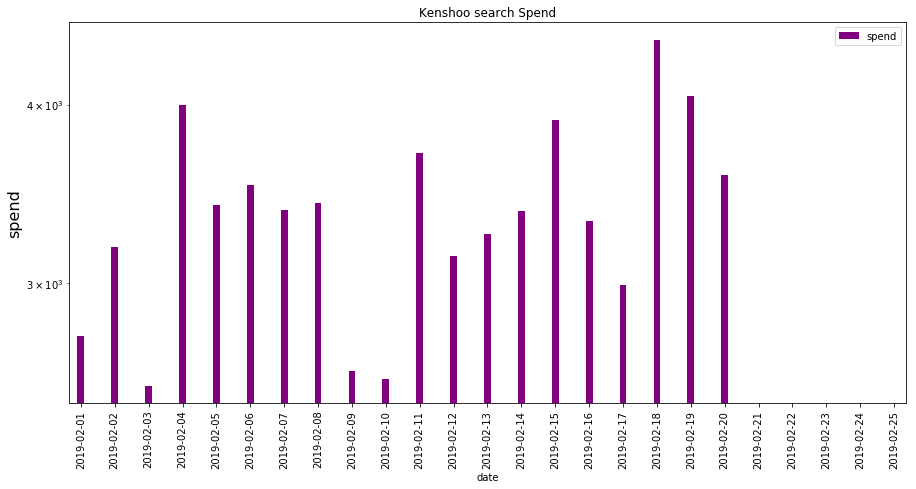

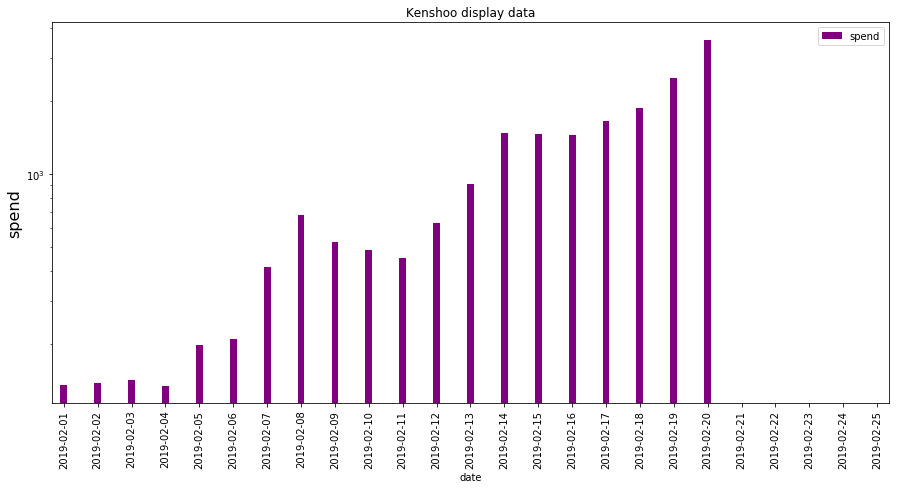

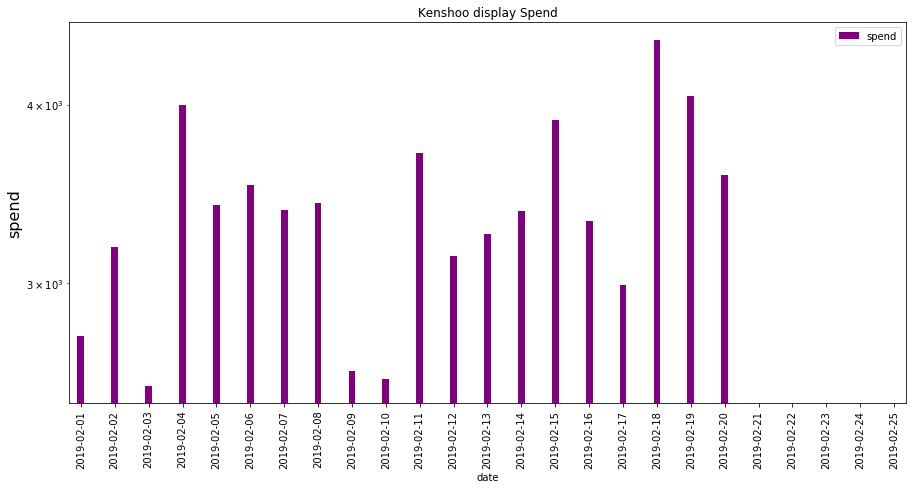

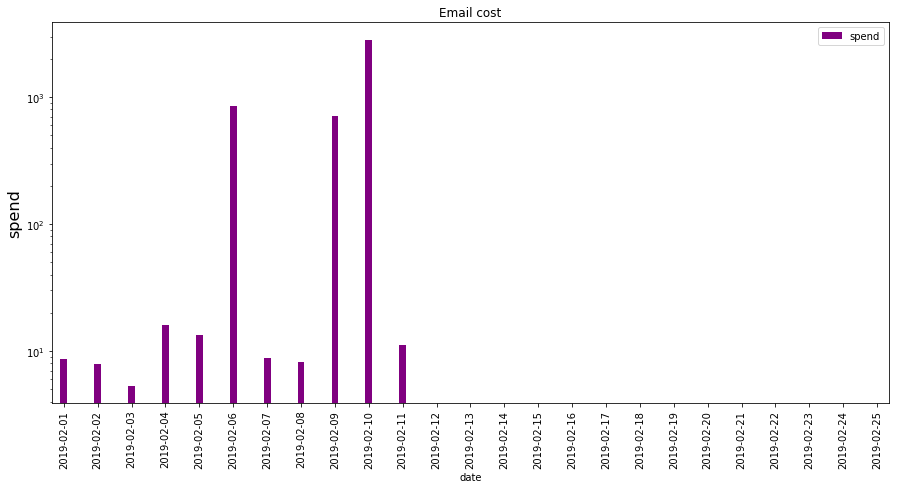

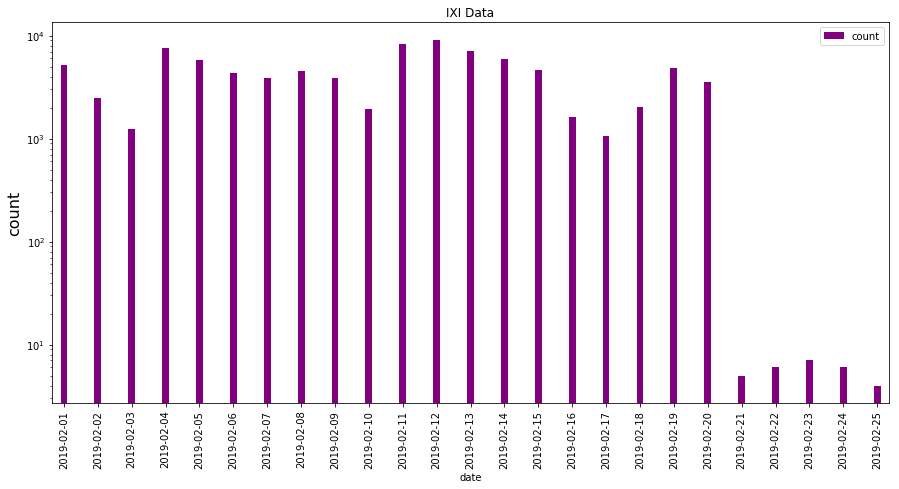

Pathing_path Files not present to Plot Conversions Per Day

Pathing_path Files not present to Plot Conversions Per Day Per channel

Pathing_path Files not present to Plot Path Length Distribution

Pathing_path Files not present to Plot Path Length Distribution per channel

Pathing_path Files not present to Plot Revenue Per day

Pathing_path Files not present to Plot Revenue Per day per channel



In [ ]:
import re
import os
import time
import pandas as pd
from google.cloud import bigquery as bq
import matplotlib as mp
import os
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
import csv
import sys
import datetime as dt
import ipdb
%matplotlib inline
arg_file='/tmp/.args'
Empty_Files=[]

def Send_Mail(Empty_Files,start_date,end_date,client):
    msg = MIMEMultipart()
    password = "epzctiadpgbckssy"
    msg['From'] = "spillai@datalicious.com"
    msg['To'] = "spillai@datalicious.com"
    msg['Subject'] = "Missing or Empty Files"
    message='Below Files are either empty or not created in GBQ for date range '+start_date +' and '  + end_date+"\n"\
             ' for '+client+"\n"+'\n'.join(Empty_Files)
    msg.attach(MIMEText(message, 'plain'))
    server = smtplib.SMTP('smtp.gmail.com: 587')
    server.starttls()
    server.login(msg['From'], password)
    server.sendmail(msg['From'], msg['To'], msg.as_string())
    server.quit()
       
def Data_Plot(row,df):
    global Empty_Files
    if row['Plot_type']=='pie':
        ax=pd.pivot_table(df, index = 'campaign').plot(kind='pie',y='count',figsize=(5,5),title=row['Title'])
        ax.set_aspect('equal')
    elif row['Plot_type']=='stack':
        if (df[list(df)[2]] == 0).all():
            print row['Description']+" Files not present to Plot " +row['Title']+"\n"
            if row['Description'] not in Empty_Files:
                Empty_Files.append(row['Description'])
        else:
            ax=pd.pivot_table(df, index = list(df)[0], columns =list(df)[1], values =list(df)[2]).plot(kind = 'bar',title=row['Title'],width=0.8,figsize=(15,7),stacked=True)
            ax.set_ylabel(list(df)[2],fontsize=16)
    else:
        if (df[list(df)[1]] == 0).all():
            print row['Description']+" Files not present to Plot " +row['Title']+"\n"
            if row['Description'] not in Empty_Files:
                Empty_Files.append(row['Description'])
        else:
            ax=pd.pivot_table(df, index = list(df)[0],values =list(df)[1]).plot(kind = 'bar',title=row['Title'],width=0.2,color='purple',figsize=(15,7))
            ax.set_yscale('log',basey=10)
            #ax.set_yticklabels(ax.get_yticks())
            ax.set_ylabel(list(df)[1],fontsize=16)
    mp.pyplot.show()
    return Empty_Files
            
            
def Create_Frame(clnt,start_date,end_date):
    global Empty_Files
    print clnt
    client= bq.Client(clnt)
    fields=[];rows=[]
    with open("query.csv","r")  as fo:
        csvreader = csv.DictReader(fo)
        for row in csvreader:
          row['Query']=row['Query'].format(client=clnt,start_date=start_date,end_date=end_date)
          try:
            df=client.query(row['Query']).to_dataframe()
            if df.empty:
                print row['Description']+" Files not present to Plot " +row['Title']+"\n"
                continue
            else:
                Empty_Files=Data_Plot(row,df)
          except Exception as e:
            continue
    return Empty_Files
    
    
def main():
    if os.path.isfile(arg_file):
        with open(arg_file,'r+') as fo:
            args = list(line for line in (val.rstrip() for val in fo) if line)
        
        client=args[0]
        start_date=args[1] if len(args)>1 else (dt.datetime.now() - dt.timedelta(11)).strftime('%Y-%m-%d')
        end_date=args[2] if len(args)>2  else (dt.datetime.now() - dt.timedelta(4)).strftime('%Y-%m-%d')
    Empty_Files=Create_Frame(client,start_date,end_date)
    if Empty_Files:
        Send_Mail(Empty_Files,start_date,end_date,client)
    
    
if __name__=="__main__":
    main()